In [ ]:
# Install dependencies
#!pip install albumentations==0.4.6
!pip install albumentations
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


### Importar json con etiquetas

In [27]:
# importing the module
import json
 
# Opening JSON file
with open('/home/jupyter/Falabella/dict_bbox_p123_revisada_cf.json') as json_file:
    dict_data = json.load(json_file)

In [28]:
# revisar
len(dict_data)

13135

### Definir clase

In [29]:
from skimage import io
class PhotosLabelsDataset_od(torch.utils.data.Dataset):
    """Photos labels dataset."""

    def __init__(self, dictionary, root_dir, transforms=None):
        """
        Args:
            xlsx_file (string): Path to the xlsx file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Boolean that indicates 
            a transformation or not.
        """
        self.dict_values = list(dictionary.values())
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.dict_values)

    def __getitem__(self, idx):

        dict_values = self.dict_values
        
        # obtener nombre fotografía
        img_name = dict_values[idx]['image_id']
        image_path = os.path.join(self.root_dir, img_name) 
        # leer imágen
        image =io.imread(image_path)
        
        # obtener 'boxes'
        boxes = dict_values[idx]['boxes']
        # calcular numero de 'boxes'
        num_box = len(boxes)
        # obtener formato adecuado para 'boxes'
        if num_box>0:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
        else:
          #negative example, ref: https://github.com/pytorch/vision/issues/2144
          boxes = torch.zeros((0, 4), dtype=torch.float32)

        # obtener área de las 'boxes'
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suponer que las instancias no forman aglomeraciones
        iscrowd = torch.zeros((num_box,), dtype=torch.int64)

        # obtener etiquetas para clase 1
        labels = torch.ones((num_box,), dtype=torch.int64)
        
        # rellenar diccionario de etiquetas 'target'
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        # si hay transformaciones, entonces se aplican al conjunto de datos
        # correspondientes
        if self.transforms:
          sample = self.transforms(image = image,
                                bboxes = target["boxes"],
                                labels = labels)
          image = sample['image']
          if len(sample['bboxes']) == 0 :
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)

          else:
            target['boxes'] = torch.Tensor(sample['bboxes'])
          
          image = image.float().div(255)
        
        return image, target

In [30]:
# Revisar dataset
path_fotografias = '/home/jupyter/Falabella/fotografias12y3'
dataset = PhotosLabelsDataset_od(dictionary = dict_data, root_dir = path_fotografias, transforms=None)
print('Length of dataset:', len(dataset), '\n')

# Obtener tamaño de imágen cualquiera y el label respectivo
img, target = dataset[325]
print('Image shape:', img.shape)
print('Label example:', target)

Length of dataset: 13135 

Image shape: (256, 192, 3)
Label example: {'boxes': tensor([[ 38.,  33., 186., 150.],
        [ 17., 138., 182., 256.]]), 'labels': tensor([1, 1]), 'area': tensor([17316., 19470.]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([325])}


In [31]:
# REFERENCIAR
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min x-max y-max
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  
  plt.show()

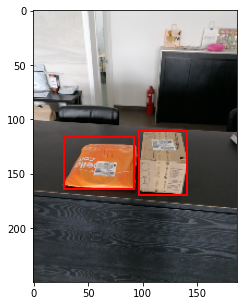

{'boxes': tensor([[ 28., 116.,  92., 164.],
        [ 97., 111., 141., 170.]]), 'labels': tensor([1, 1]), 'area': tensor([3072., 2596.]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([9])}


In [32]:
# mostrar imágen con bbox e imprimir target
img, target = dataset[9]
plot_img_bbox(img, target)
print(target)

### Separar data en train y val

In [33]:
# separar diccionario en train y test antes de generar el dataset
from sklearn.model_selection import train_test_split

rs = 0
s = pd.Series(dict_data)
train_data , test_data  = [i.to_dict() for i in train_test_split(s, train_size=0.8, random_state=rs)]

print('train: ', len(train_data))
print('test: ', len(test_data))

train:  10508
test:  2627


In [34]:
# función para contabilizar elementos de cada clase
def labels_quantity(dic):
  positive = 0
  negative = 0
  for i in dic:
    if dic[i]['labels']:
      positive+=1
    else:
      negative+=1
  return positive, negative

In [35]:
p_train, n_train = labels_quantity(train_data)
p_test, n_test = labels_quantity(test_data)

print('p_train: ', p_train, ' ', 'n_train', n_train)
print('p_test: ', p_test, ' ', 'n_test', n_test)

p_train:  7946   n_train 2562
p_test:  1939   n_test 688


### Transformaciones

In [36]:
# Inicializar transformaciones

# normalización para conjunto de validación 
val_transform = A.Compose(
        [
         # ToTensorV2 converts image to pytorch tensor without div by 255
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         ) 

# transformaciones para conjunto de train
train_transform_0 = A.Compose(
        [
            A.Resize (480, 480),
         A.HorizontalFlip(0.5),
         A.VerticalFlip(0.5),
         A.RandomBrightnessContrast(p=0.5),
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )

train_transform_1 = A.Compose(
        [
            A.Resize (480, 480),
            A.RandomCrop(width=432, height=432, p=0.5), # recorte de 90%
         A.HorizontalFlip(0.5),
         A.VerticalFlip(0.5),
         A.RandomBrightnessContrast(p=0.5),
         ToTensorV2(p=1.0)
         ],
         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
         )

### Dataset con primera configuración de transformación

In [37]:
train_transform = train_transform_0
path_fotografias = '/home/jupyter/Falabella/fotografias12y3'
train_set = PhotosLabelsDataset_od(dictionary = train_data, root_dir = path_fotografias, transforms=train_transform)
test_set = PhotosLabelsDataset_od(dictionary = test_data, root_dir = path_fotografias, transforms=val_transform)

### Dataset con segunda configuración de transformación

In [38]:
# dataset con primera configuración de transformación
train_transform = train_transform_1
path_fotografias = '/home/jupyter/Falabella/fotografias12y3'
train_set = PhotosLabelsDataset_od(dictionary = train_data, root_dir = path_fotografias, transforms=train_transform)
test_set = PhotosLabelsDataset_od(dictionary = test_data, root_dir = path_fotografias, transforms=val_transform)

### Generar batches de train y val

In [39]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10,
                        shuffle=True, num_workers=4, 
                         collate_fn=utils.collate_fn,)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10,
                        shuffle=False, num_workers=4, 
                        collate_fn=utils.collate_fn,)

### Función para cargar modelo

In [40]:
# REFERENCIAR!
# función de ayuda para cargar modelo
def get_object_detection_model(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

### Funciones "eval_forward" y "evaluate_loss" para calcular perdidas
Obtenido de https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch

In [41]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [42]:
#I determine validation loss by looking at the losses dictionary, 
#sum all of these losses, and at the end average them by the length of the dataloader
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    with torch.no_grad():
      for images, targets in data_loader:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          losses_dict, detections = eval_forward(model, images, targets)
         
          losses = sum(loss for loss in losses_dict.values())

          val_loss += losses
          
    validation_loss = val_loss/ len(data_loader)    
    return validation_loss

## Entrenamiento

### Función de entrenamiento con early stop

In [44]:
def train_early_stop(name, num_epochs, epochs_limit, model, optimizer, \
                     trainloader, testloader, device, model_path, \
                     print_freq = 100):
    """
    Args:
        name (str): nombre del modelo
        num_epochs (int): numero de épocas de entrenamiento
        epochs_limit (int): límite de épocas para detener early stopping
        model: modelo
        optimizer: optimizador
        trinloader: batches de entrenamiento
        tesloader: batches de validación
        device (str): dispositivo en el cual entrenar
        model_path (str): ubicación en donde se guardarán parámetros del modelo
        print_freq: numero de batches para imprimir info.
          
    Returns:
       model_dict (dict): toda la info. del modelo entrenado    
    """
    # mover modelo al dispositivo 
    model.to(device)
    # inicializar pérdida de validación inicial
    validation_loss_ini = 1000
    # inicializar listas para almacenar pérdidas (train y val)
    train_losses = []
    val_losses = []
    # inicializar variable epochs
    epochs = 0
    # inicializar diccionario evaluation_dic
    evaluation_dic = {}
    for epoch in range(num_epochs):
        # entrenamiento por epoca
        train_one_epoch(model, optimizer, trainloader, device, epoch, print_freq)
        # actualizar learning rate
        lr_scheduler.step()
    
        # función para calcular pérdidas de entrenamiento y validación
        training_loss = evaluate_loss(model, trainloader, device=device)
        # guardar pérdida de entrenamiento en lista
        train_losses.append(training_loss)
        print('training_loss:', training_loss)
    
        validation_loss  = evaluate_loss(model, testloader, device=device)
        # guardar perdida de validación en lista
        val_losses.append(validation_loss)
        print('validation_loss:', validation_loss) 
    
        # Early stopping
        
        # si pérdida de validación es menor a la mínima pérdida de validación
        # obtenida hasta el momento, se guarda el modelo
        if validation_loss < validation_loss_ini:
          # se guarda el modelo
          torch.save({
              'train_losses': train_losses,
              'val_losses': val_losses,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'validation loss': validation_loss,
                }, model_path)
          # se actualiza validation_loss
          validation_loss_ini = validation_loss
          # se actualiza variable epochs
          epochs = 0
        
        # si pérdida de validación es mayor o igual a la mínima pérdida de validación
        # obtenida hasta el momento y además, las epocas son menor al límite de epocas
        # propuesto, entonces se actualiza variable epochs
        elif validation_loss >= validation_loss_ini and epochs < epochs_limit:
          # se actualiza variable epochs  
          epochs += 1
    
        else:
          # se termina entrenamiento
          break
        
        # evaluar métricas en el test 
        evaluation = evaluate(model, testloader, device=device)
        key = 'epoch_' + str(epoch)
        evaluation_dic[key] = evaluation
        
    # actualizar diccionario con todas las pérdidas (train y val) 
    model_dict = torch.load(model_path)
    model_dict['name'] = name
    model_dict['train_losses'] = train_losses
    model_dict['val_losses'] = val_losses
    model_dict['evaluation_dic'] = evaluation_dic
    
    torch.save(model_dict, model_path)
    
    print('Finished Training')
    
    return model_dict

### Función de entrenamiento con todo el dataset

In [45]:
def train_all_set(name, num_epochs, model, optimizer, \
                     dataloader, device, model_path, \
                  print_freq = 100):
    """
    Args:
        name (str): nombre del modelo
        num_epochs (int): numero de épocas de entrenamiento
        model: modelo
        optimizer: optimizador
        trinloader: batches de entrenamiento
        tesloader: batches de validación
        device (str): dispositivo en el cual entrenar
        model_path (str): ubicación en donde se guardarán parámetros del modelo
        print_freq: numero de batches para imprimir info.
          
    Returns:
       model_dict (dict): toda la info. del modelo entrenado    
    """
    # mover modelo al dispositivo 
    model.to(device)
    for epoch in range(num_epochs):
        # entrenamiento por epoca
        train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        # actualizar learning rate
        lr_scheduler.step()
    
    # se guarda el modelo
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)
    
    # cargar modelo
    model_dict = torch.load(model_path)
    model_dict['name'] = name
    
    torch.save(model_dict, model_path)
    
    print('Finished Training')
    
    return model_dict

### Entrenar modelo con early stopping

In [46]:
# entrenar en gpu si es posible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# definir numero de clases
num_classes = 2 # one class (class 0) is dedicated to the "background"

# obtener modelo mediante función de ayuda
model = get_object_detection_model(num_classes)

# optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# se define un learning rate scheduler que decrementa el learning rate por 
# 10x cada 3 epocas -> ej: 0.005 si epoca < 3, 0.0005 si 3 <= epoca < 6, etc
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [ ]:
# Entrenar modelo
num_epochs = 100
epochs_limit = 5
model_path = '/home/jupyter/Falabella/model_cf_12y3_2.pth'
name = 'model_cf_12y3_2'

model_dict = train_early_stop(name, num_epochs, epochs_limit, model, \
                 optimizer, trainloader, testloader, device, model_path, \
                 print_freq = 100)

Epoch: [0]  [   0/1051]  eta: 0:42:29  lr: 0.000010  loss: 0.7590 (0.7590)  loss_classifier: 0.6468 (0.6468)  loss_box_reg: 0.0971 (0.0971)  loss_objectness: 0.0108 (0.0108)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 2.4256  data: 0.5423  max mem: 10315
Epoch: [0]  [ 100/1051]  eta: 0:31:12  lr: 0.000509  loss: 0.1813 (0.3015)  loss_classifier: 0.0642 (0.1698)  loss_box_reg: 0.1092 (0.1160)  loss_objectness: 0.0056 (0.0104)  loss_rpn_box_reg: 0.0043 (0.0053)  time: 2.0359  data: 0.0217  max mem: 10315
Epoch: [0]  [ 200/1051]  eta: 0:28:44  lr: 0.001009  loss: 0.1575 (0.2415)  loss_classifier: 0.0500 (0.1130)  loss_box_reg: 0.0946 (0.1093)  loss_objectness: 0.0042 (0.0139)  loss_rpn_box_reg: 0.0043 (0.0053)  time: 2.0935  data: 0.0203  max mem: 10315
Epoch: [0]  [ 300/1051]  eta: 0:25:38  lr: 0.001508  loss: 0.0865 (0.1995)  loss_classifier: 0.0297 (0.0889)  loss_box_reg: 0.0506 (0.0937)  loss_objectness: 0.0028 (0.0120)  loss_rpn_box_reg: 0.0035 (0.0049)  time: 2.1002  data: 0.0225  max

### Graficar curva de pérdidas

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

train_losses = model_dict['train_losses']
val_losses = model_dict['val_losses']

# training and validation loss
mpl.style.use('seaborn')
plt.plot(list(range(len(train_losses))), train_losses, 'teal', label='Training loss')
plt.plot(list(range(len(val_losses))), val_losses, 'orange', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Entrenamiento con todo el dataset

In [ ]:
# cargar modelo ya entrenado
num_classes = 2
model = get_object_detection_model(num_classes)
model_dict = torch.load(model_path)
model.load_state_dict(model_dict['model_state_dict'])

In [ ]:
# obtener epoca óptima
optimal_epoch = model_dict['epoch']
print(optimal_epoch)

In [ ]:
# generar dataset
# FIJARSE QUE TRANSFORMACIÓN SEA LA MISMA CON LA CUAL SE REALIZÓ 
# EL EARLY STOPPING
dataset = PhotosLabelsDataset_od(dictionary = dict_data, root_dir = path_fotografias, transforms=train_transform)

In [ ]:
# comprobar largo dataset
len(dataset)

In [ ]:
# generar baches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10,
                        shuffle=True, num_workers=4, 
                        collate_fn=utils.collate_fn,)

#### Re-inicializar el modelo con mismos parámetros que para early stopping

In [ ]:
# entrenar en gpu si es posible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# definir numero de clases
num_classes = 2 # one class (class 0) is dedicated to the "background"

# obtener modelo mediante función de ayuda
model = get_object_detection_model(num_classes)

# optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# se define un learning rate scheduler que decrementa el learning rate por 
# 10x cada 3 epocas -> ej: 0.005 si epoca < 3, 0.0005 si 3 <= epoca < 6, etc
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [ ]:
# Entrenar modelo

num_epochs = 100
epochs_limit = 5
model_path = '/home/jupyter/Falabella/model_cf_12y3_2_full.pth'
name = 'model_cf_12y3_2_full'

model_dict = train_all_set(name, num_epochs, model, optimizer, \
                     dataloader, device, model_path, \
                  print_freq = 100):

In [ ]:
# training for 5 epochs
num_epochs = optimal_epoch
#PATH = './model_sf.pth'
PATH = '/home/jupyter/Falabella/model_cf_12y3_1.pth'

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
# se guarda el modelo
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

## Evaluación modelo

### Revisión del modelo en algunas imágenes de test

#### Función para dibujar true_bbox y predicted_bbox

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target, axs, i, j, device, prediction = None):
  axs[i,j].imshow(img.to(device))
  
  if prediction:
    boxes = target['boxes'].to(device)
    indice = 0
    for score in target['scores']:
      if score >= 0.5:
        box = boxes[indice]
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle(
          (x, y),
          width, height,
          linewidth = 2,
          edgecolor = 'b',
          facecolor = 'none'
        )
        # Draw the bounding box on top of the image
        axs[i,j].add_patch(rect) 
      indice+=1      
  
  else:
    for box in (target['boxes'].to(device)):
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'r',
        facecolor = 'none'
      )
      # Draw the bounding box on top of the image
      axs[i,j].add_patch(rect)

#### Imágenes

In [ ]:
# Visualización de algunas imagenes 
w, h = 6, 6
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
for i in range(h):
  for j in range(w):
    img, label = test_set[idx]
    idx+=1
    plot_img_bbox(img.permute(1,2,0), label, axs, i, j, 'cpu')

In [ ]:
# Visualización de predicciones
w, h = 6, 6
fig, axs = plt.subplots(h, w, figsize=(4*w,4*h))
idx=0
device = 'cuda'
model.to(device)
model.eval()              # turn the model to evaluate mode
with torch.no_grad():     # does not calculate gradient
  for i in range(h):
    for j in range(w):
      img, _ = test_set[idx]
      prediction = model([img.to(device)])
      idx+=1
      plot_img_bbox(img.permute(1,2,0), prediction[0], axs, i, j, 'cpu', True)

### Prueba con 1000_test

In [ ]:
# función para calcular accuracy 1:1, obtener true_labels, predicciones
# y scores
import os
from skimage import io, transform

def od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda'):
  acc = 0
  df = pd.read_excel(path_xlsx)
  model.to(device)
  model.eval()              # turn the model to evaluate mode
  count = 0
  #y_test = []
  y_true = []
  y_pred = []
  y_score = []
  aciertos = 0
  with torch.no_grad():
    for img_name in os.listdir(path_images):
      full_img_name = os.path.join(path_images, img_name)
      image =io.imread(full_img_name)
      t_img = transform.resize(image, (480, 480))
      t_img = torch.Tensor(t_img).permute(2,0,1).to(device)
      prediction = model([t_img])
      if prediction[0]['labels'].shape[0] > 0 and max(prediction[0]['scores']).item() >= 0.5:
      #if prediction[0]['labels'].shape[0] > 0: 
        pred_class = 1
      else:
        pred_class = 0
      y_pred.append(pred_class)
      indice = int(img_name.split('.')[0])
      true_class = df.loc[indice]['Producto']
      #y_test.append(true_class)
      y_true.append(true_class)
      if prediction[0]['labels'].shape[0] > 0:
        y_score.append(max(prediction[0]['scores']).item())
      else:
        y_score.append(0)
      if pred_class == true_class:
        aciertos += 1
      else:
        pass
      count+=1
    acc = aciertos/count

    return acc, y_true, y_pred, y_score

In [ ]:
path_images = '/home/jupyter/Falabella/test_1000_imagenes/imagenes'
path_xlsx= '/home/jupyter/Falabella/test_1000_imagenes/etiquetado ML_revisada.xlsx'
od_acc, y_true_list, y_pred_list, y_score_list= od_acc_1000_test(model, path_images, path_xlsx, device = 'cuda')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calculamos la curva ROC para etiqueta
fpr, tpr, _ = roc_curve(y_true_list , y_score_list)
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
auc = roc_auc_score(y_true_list, y_score_list)
label = 'auc:' + str(round(auc,2))
plt.plot(fpr, tpr, marker='.', label = label, color = 'green')
# Etiquetas de los ejes
plt.title('Paquete')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc = 'lower right' )
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
#y_test = np.array(y_test_list)
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)
#cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
accuracy = (cf_matrix[0][0]+cf_matrix[1][1])/(cf_matrix[0][0] + cf_matrix[0][1] + cf_matrix[1][0]+cf_matrix[1][1])
recall = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[0][1])
precision = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0])
F1 = 2*recall*precision/(recall + precision)
print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nada','Producto'])
ax.yaxis.set_ticklabels(['Nada','Producto'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
#y_test = np.array(y_test_list)
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)
#cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
accuracy = (cf_matrix[0][0]+cf_matrix[1][1])/(cf_matrix[0][0] + cf_matrix[0][1] + cf_matrix[1][0]+cf_matrix[1][1])
recall = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[0][1])
precision = cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0])
F1 = 2*recall*precision/(recall + precision)
print('accuracy:', accuracy, 'recall:', recall, 'precision:', precision, 'F1:', F1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Nada','Producto'])
ax.yaxis.set_ticklabels(['Nada','Producto'])

## Display the visualization of the Confusion Matrix.
plt.show()